In [1]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!unzip "gdrive/MyDrive/datasets/challenges-in-representation-learning-facial-expression-recognition-challenge.zip" -d 'datasets'

Archive:  gdrive/MyDrive/datasets/challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: datasets/example_submission.csv  
  inflating: datasets/fer2013.tar.gz  
  inflating: datasets/icml_face_data.csv  
  inflating: datasets/test.csv       
  inflating: datasets/train.csv      


In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from typing import Tuple

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras

from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

!pip install git+https://github.com/tensorflow/docs

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

!pip install mlxtend --upgrade --no-deps
import mlxtend                                                      
print(mlxtend.__version__) 

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-d6pm_pp5
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-d6pm_pp5
  Resolved https://github.com/tensorflow/docs to commit c1510dc5ad73aa829249822798e6263360b0f62a
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180353 sha256=56148508e26e8af6340d369da8b8f18d3b2f8abf26359757a9e5af2982e43d3d
  Stored in directory: /tmp/pip-ephem-wheel-cache-shz_jlgx/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.1 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing insta

In [10]:
root_dir = '/content/datasets/'
full_data_file_name = 'icml_face_data.csv'
train_data_file_name = 'train.csv'
test_data_file_name = 'test.csv'

In [11]:
df = pd.read_csv(root_dir + full_data_file_name)
df.columns = ('emotion', 'Usage', 'pixels')
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [12]:
#split data into training, validation and test set
data_train = df[df['Usage']=='Training'].copy()
data_val   = df[df['Usage']=='PublicTest'].copy()
data_test  = df[df['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [13]:
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [14]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = keras.utils.to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


In [15]:
inputs = keras.Input(shape=(48, 48, 1), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(7, activation='softmax')(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

Model: "toy_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 46, 46, 32)   320         ['img[0][0]']                    
                                                                                                  
 conv2d_1 (Conv2D)              (None, 44, 44, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 64)   0           ['conv2d_1[0][0]']               
                                                                                         

In [16]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=1, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/50


<ipython-input-16-0e66acf67115>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),


448/448 [==============================] - 30s 42ms/step - loss: 1.8141 - accuracy: 0.2478 - val_loss: 1.7916 - val_accuracy: 0.2555
Epoch 2/50
448/448 [==============================] - 21s 46ms/step - loss: 1.7912 - accuracy: 0.2549 - val_loss: 1.7535 - val_accuracy: 0.2756
Epoch 3/50
448/448 [==============================] - 18s 40ms/step - loss: 1.7278 - accuracy: 0.2866 - val_loss: 1.7304 - val_accuracy: 0.2887
Epoch 4/50
448/448 [==============================] - 18s 40ms/step - loss: 1.6341 - accuracy: 0.3409 - val_loss: 1.5062 - val_accuracy: 0.4260
Epoch 5/50
448/448 [==============================] - 18s 41ms/step - loss: 1.4719 - accuracy: 0.4298 - val_loss: 1.3839 - val_accuracy: 0.4709
Epoch 6/50
448/448 [==============================] - 18s 40ms/step - loss: 1.3898 - accuracy: 0.4686 - val_loss: 1.3204 - val_accuracy: 0.5001
Epoch 7/50
448/448 [==============================] - 18s 40ms/step - loss: 1.3316 - accuracy: 0.4920 - val_loss: 1.2520 - val_accuracy: 0.5263
Epo

In [17]:
test_loss, test_acc = model.evaluate(test_X, test_Y)
test_acc

113/113 [==============================] - 1s 5ms/step - loss: 0.9798 - accuracy: 0.6236


0.623572051525116

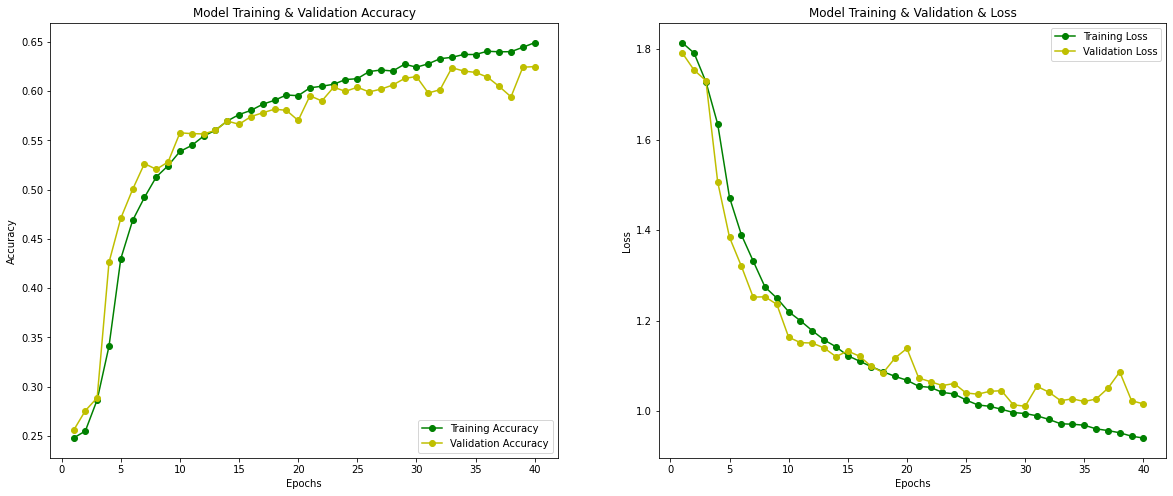

In [18]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [19]:
model.save('model')
model.save('modelh5', save_format='h5')
# model = keras.models.load_model("model")

In [20]:
#make prediction
test_y = np.argmax(test_Y, axis=1)
test_yhat = np.argmax(model.predict(test_X), axis=1)

113/113 [==============================] - 0s 3ms/step


[[241   1  59  27  71  11  81]
 [ 30   6   8   5   3   2   1]
 [ 61   0 193  23 127  62  62]
 [  6   0  25 779  28  16  25]
 [ 54   0  52  41 302  10 135]
 [ 12   0  59  22   7 301  15]
 [ 26   1  37  50  89   7 416]]


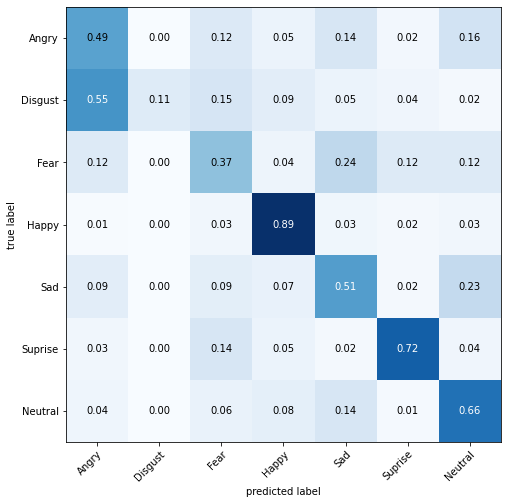

In [21]:
emotions = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Suprise',
    6: 'Neutral'
}

#get confusion matrix
cm = confusion_matrix(test_y, test_yhat)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

In [24]:
!zip -r /content/model_03.zip /content/model

updating: content/model/ (stored 0%)
updating: content/model/saved_model.pb (deflated 89%)
updating: content/model/variables/ (stored 0%)
updating: content/model/variables/variables.index (deflated 69%)
updating: content/model/variables/variables.data-00000-of-00001 (deflated 14%)
updating: content/model/keras_metadata.pb (deflated 93%)
updating: content/model/assets/ (stored 0%)
updating: content/model/fingerprint.pb (stored 0%)
